<a href="https://colab.research.google.com/github/OlegBEZb/NLP_advanced_course/blob/master/HW2/HW2_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About notebook

Dataset
*	Groningen Meaning Bank (version 2.2.0)
*	Task: named entity recognition
*	Target – named entity tags (BIO + entity type)
*	Input data: 
  * Use “en.met” files to extract the subcorpus
  corpus = 'Voice of America' (for honogeneity of the input data set)
  * Use "en.tags" files for the main input data:
      *	raw tokens + may use the lemmas and the POS-tags 
  (i.e. take the “golden” POS-tagging);
      *	which means:
        *	first three columns for input: ['word', 'pos', 'lemma']
        *	the fourth column for target variable (‘ne_tags’)
        (BIO annotation + the named-entity type in one tag)  

# Tasks

1.	The most trivial model = supervised HMM:
  *	Take hmmlearn (former sklearn), modify MultinomialHMM (I.e. inherit a new class from _BaseHMM making it a modified copy of the latter) to allow for supervised HMM training. The states of the HMM model = the NE tags.
  *	NOTE: may use NaiveBayes to learn emission probabilities in a supervized manner.
  *	Or implement from scratch (with Viterbi for prediction).
  *	NOTE: use tuples of features for X (not just the word, but additional info).
  *	NOTE: use smoothing for state transitions.
2.	CRF
  *	Modify the input features;
  *	Use CRFSuite.
3.	Bi-LSTM:
  *	Use keras or tensorflow;
  *	https://github.com/hse-aml/natural-language-processing/blob/master/week2/week2-NER.ipynb
  *	A plus for incorporating CNN-layers;

# Metrics

* normalized confusion matrices, precision, recall, F-score 
(macro- and micro-) 
* (token level, entity level, partial matching (i.e. boundary-detection problem), binary).  
NOTE: taking into account vocabulary transfer is a plus.

http://www.davidsbatista.net/blog/2018/05/09/Named_Entity_Evaluation/  
http://larsmans.github.io/seqlearn/reference.html#module-seqlearn.datasets

# Evaluation Criteria

Scoring (14.5 max):  
*	Dataset overview – 0.5
  *	text lengths, vocabulary size, frequencies of patterns (<UNK-type-i>) 
  *	stats over the target tags
*	Feature engineering – 2 (1+1)
  *	grammatical words = closed set (~ stop words)
  *	Stemming + POS
  *	Word shape
  *	Ad hoc features ( +1)  
*	Word patterns -> encode types of unknown words +0.5
*	Smoothing in HMM – 0.5 
  *	In HMM: for state transitions.
*	Incorporating tupled features in HMM (on top of tokens) – 1
*	The correct HMM implementation – 1
*	More fine-grained feature engineering for the Neural Network + 0.5
  *	Differentiate between POS-relevancy for the word and the context, etc.
  *	Sentence-level features (may use “golden” sentence-splitting)
*	Evaluation (on all levels) – 1
*	Conclusion on HMM deficiency (as a model) – 1
*	CRF: 1 point for use and evaluation, + 0.5 points for comparison and conclusions;
*	NN:
  *	Main network: 4
  *	CNN layers: +2  

Libraries: hmmlearn, crfsuite, tensorflow, keras

# Libs import

## Downloading, upgrading libs, fixing bug in seqlearn

In [0]:
!pip install sklearn-crfsuite
!pip install -U scipy
!pip install seqlearn

There is unsolved issue https://github.com/larsmans/seqlearn/issues/45  
And there is no opportunity to use lower version of scipy because of other dependencies

In [29]:
!rm /usr/local/lib/python3.6/dist-packages/seqlearn/hmm.py

rm: cannot remove '/usr/local/lib/python3.6/dist-packages/seqlearn/hmm.py': No such file or directory


In [30]:
%%writefile /usr/local/lib/python3.6/dist-packages/seqlearn/hmm.py

"""Hidden Markov models (HMMs) with supervised training."""

import numpy as np
#from scipy.misc import logsumexp
from scipy.special import logsumexp

from .base import BaseSequenceClassifier
from ._utils import atleast2d_or_csr, count_trans, safe_sparse_dot


class MultinomialHMM(BaseSequenceClassifier):
    """First-order hidden Markov model with multinomial event model.

    Parameters
    ----------
    decode : string, optional
        Decoding algorithm, either "bestfirst" or "viterbi" (default).
        Best-first decoding is also called posterior decoding in the HMM
        literature.

    alpha : float
        Lidstone (additive) smoothing parameter.
    """

    def __init__(self, decode="viterbi", alpha=.01):
        self.alpha = alpha
        self.decode = decode

    def fit(self, X, y, lengths):
        """Fit HMM model to data.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            Feature matrix of individual samples.

        y : array-like, shape (n_samples,)
            Target labels.

        lengths : array-like of integers, shape (n_sequences,)
            Lengths of the individual sequences in X, y. The sum of these
            should be n_samples.

        Notes
        -----
        Make sure the training set (X) is one-hot encoded; if more than one
        feature in X is on, the emission probabilities will be multiplied.

        Returns
        -------
        self : MultinomialHMM
        """

        alpha = self.alpha
        if alpha <= 0:
            raise ValueError("alpha should be >0, got {0!r}".format(alpha))

        X = atleast2d_or_csr(X)
        classes, y = np.unique(y, return_inverse=True)
        lengths = np.asarray(lengths)
        Y = y.reshape(-1, 1) == np.arange(len(classes))

        end = np.cumsum(lengths)
        start = end - lengths

        init_prob = np.log(Y[start].sum(axis=0) + alpha)
        init_prob -= logsumexp(init_prob)
        final_prob = np.log(Y[start].sum(axis=0) + alpha)
        final_prob -= logsumexp(final_prob)

        feature_prob = np.log(safe_sparse_dot(Y.T, X) + alpha)
        feature_prob -= logsumexp(feature_prob, axis=0)

        trans_prob = np.log(count_trans(y, len(classes)) + alpha)
        trans_prob -= logsumexp(trans_prob, axis=0)

        self.coef_ = feature_prob
        self.intercept_init_ = init_prob
        self.intercept_final_ = final_prob
        self.intercept_trans_ = trans_prob

        self.classes_ = classes

        return self

Writing /usr/local/lib/python3.6/dist-packages/seqlearn/hmm.py


## Importing libs

In [113]:
%autosave 180
%load_ext autoreload
%autoreload 2

from nltk import word_tokenize, pos_tag, ne_chunk
from copy import deepcopy
import os
import numpy as np
import pandas as pd
import codecs
from collections import Counter
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.pipeline import Pipeline
from sklearn_crfsuite import CRF
from sklearn.metrics import recall_score, roc_auc_score, make_scorer, f1_score, fbeta_score

from seqlearn.hmm import MultinomialHMM
from seqlearn.evaluation import SequenceKFold
from seqlearn.evaluation import bio_f_score

%matplotlib inline

Autosaving every 180 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Configs

In [0]:
COLAB = True
test_size = 0.2
subcorpus = 'Voice of America'

The raw data was preprocessed on my own PC bacause of google drive limitations.

In [3]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    data_folder = '/content/drive/My Drive/Advanced NLP/Homework 2: Named entity recognition on Groningen Meaning Bank dataset'
else:
    data_folder = 'D:\Data\gmb-2.2.0\data'
    print('data found:', os.listdir(data_folder))
    
print('data found:', os.listdir(data_folder))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
data found: ['HW1. NER.ipynb', 'Voice of America.csv']


# Data extraction

Parsing data from "Voice of America" subcorpus. According to the instructions we take first four columns and additional column to separate data on texts, sentences or words.

In [0]:
%%time

voa_data = pd.DataFrame(columns=['word', 'pos', 'lemma', 'ne_tags', 'text_id'])

os.chdir(data_path)
part_paths = os.listdir()

for part_path in tqdm(part_paths, total=len(part_paths)):
    os.chdir(part_path)
    document_paths = os.listdir()
    for document_path in document_paths:
        os.chdir(document_path)
        f = codecs.open("en.met", 'r', "utf_8_sig")
        file_met = f.read()
        if ('subcorpus: {}'.format(subcorpus) in file_met):
            tags_df = pd.read_csv('en.tags',
                                  sep='\t',
                                  header=None,
                                  names=['word', 'pos', 'lemma', 'ne_tags'],
                                  usecols=[0, 1, 2, 3],
                                  error_bad_lines=False)
            tags_df['text_id'] = str(part_path) + '_' + str(document_path)
            voa_data = voa_data.append(tags_df, ignore_index=True)
        f.close()
        os.chdir('..')
    os.chdir('..')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:55<00:00,  5.36s/it]

Wall time: 8min 55s


In [0]:
def show_memory_usage(df):
    print("memory usage: ", df.memory_usage().sum()/1024/1024, " MB")

In [0]:
show_memory_usage(voa_data)

memory usage:  46.969688415527344  MB


In [0]:
voa_data.head()

,word,pos,lemma,ne_tags,text_id
0,Thousands,NNS,thousand,O,p00_d0018
1,of,IN,of,O,p00_d0018
2,demonstrators,NNS,demonstrator,O,p00_d0018
3,have,VBP,have,O,p00_d0018
4,marched,VBN,march,O,p00_d0018


In [0]:
voa_data.shape

(1231279, 5)

Number of tokens coincided with the declared in README file

## Make BIO

Classificators work better if avoid redundant granularity. Also such detailed fragmentation has no value for the task of only finding named entities. Thus, we can combine subcategories and leave only first part of tag.

In [10]:
voa_data['ne_tags'] = voa_data['ne_tags'].apply(lambda x: x.split('-')[0])

voa_data['ne_tags'].value_counts()

O      1032479
geo      55480
org      44659
per      43168
tim      30097
gpe      19685
[]        4064
art        790
eve        577
nat        280
Name: ne_tags, dtype: int64

In [0]:
def use_prev_value_decorator(func):
    prev_tag = "O"

    def wrapper(curr_tag, **kwargs):
        nonlocal prev_tag
        bio_tag = func(curr_tag, prev_tag)
        prev_tag = curr_tag
        return bio_tag

    return wrapper


@use_prev_value_decorator
# Tag tokens with standard NLP BIO tags
def bio_tagger(curr_tag, prev_tag):
    if curr_tag == "O":  #O
        return curr_tag
    elif curr_tag != "O" and prev_tag == "O":  # Begin NE
        return "B-" + curr_tag
    elif prev_tag != "O" and prev_tag == curr_tag:  # Inside NE
        return "I-" + curr_tag
    elif prev_tag != "O" and prev_tag != curr_tag:  # Adjacent NE
        return "B-" + curr_tag

In [13]:
%%time 

voa_data['bio_tag'] = voa_data['ne_tags'].apply(bio_tagger, axis=1)

print(voa_data['bio_tag'].value_counts().head())

O        1032479
B-geo      46622
B-org      24133
B-tim      23302
I-per      21799
Name: bio_tag, dtype: int64
CPU times: user 762 ms, sys: 6.99 ms, total: 769 ms
Wall time: 769 ms


In [14]:
voa_data.head(2)

,word,pos,lemma,ne_tags,text_id,bio_tag
0,Thousands,NNS,thousand,O,p00_d0018,O
1,of,IN,of,O,p00_d0018,O


In [0]:
voa_data.to_csv(os.path.join(data_folder,'{}.csv'.format(subcorpus)), index=False)

Possible investigation: check if loop for column would be faster

# EDA

In [4]:
if COLAB:
    voa_data = pd.read_csv(os.path.join(data_folder,'{}.csv'.format(subcorpus)))
else:
    voa_data = pd.read_csv('D:\Data\gmb-2.2.0\{}.csv'.format(subcorpus))
voa_data.head()

,word,pos,lemma,ne_tags,text_id,bio_tag
0,Thousands,NNS,thousand,O,p00_d0018,O
1,of,IN,of,O,p00_d0018,O
2,demonstrators,NNS,demonstrator,O,p00_d0018,O
3,have,VBP,have,O,p00_d0018,O
4,marched,VBN,march,O,p00_d0018,O


In [18]:
def average_text_length(text_id):
    doc_lengths = list(dict(Counter(text_id)).values())
    sum = 0
    for length in doc_lengths:
        sum += length
    return sum/len(doc_lengths)

print("average text length: ", average_text_length(voa_data['text_id']))

average text length:  134.31646121959201


In [19]:
voa_data.describe()

,word,pos,lemma,ne_tags,text_id,bio_tag
count,1231279,1231279,1231279,1231279,1231279,1231279
unique,35154,48,27209,10,9167,19
top,the,NN,the,O,p00_d0090,O
freq,61398,168817,74941,1032479,388,1032479


In [20]:
voa_data['ne_tags'].value_counts()

O      1032479
geo      55480
org      44659
per      43168
tim      30097
gpe      19685
[]        4064
art        790
eve        577
nat        280
Name: ne_tags, dtype: int64

In [21]:
voa_data['bio_tag'].value_counts()

O        1032479
B-geo      46622
B-org      24133
B-tim      23302
I-per      21799
B-per      21369
I-org      20526
B-gpe      19469
I-geo       8858
I-tim       6795
B-[]        4061
B-art        455
I-art        335
B-eve        316
I-eve        261
B-nat        225
I-gpe        216
I-nat         55
I-[]           3
Name: bio_tag, dtype: int64

# Preprocessing

In [0]:
def get_sentences(df, word_col='word', pos_col='pos', 
                  tag_col='bio_tag', id_col='text_id'):
    """func to get the sentences in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_n, Tag_n)]"""
    
    agg_func = lambda s: [(w, p, t) for w, p, t in zip(s[word_col].values.tolist(),
                                                       s[pos_col].values.tolist(),
                                                       s[tag_col].values.tolist())]
    grouped = df.groupby(id_col).apply(agg_func)
    sentences = [s for s in grouped]
    
    return sentences

In [6]:
%%time

word_pos_tag_sentences = get_sentences(voa_data)

CPU times: user 1.29 s, sys: 79.1 ms, total: 1.37 s
Wall time: 1.37 s


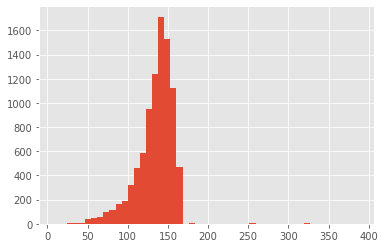

In [7]:
#Lets visualize how the sentences are distributed by their length
plt.style.use("ggplot")
plt.hist([len(s) for s in word_pos_tag_sentences], bins=50)
plt.show()

create featuretfransformer like in https://www.depends-on-the-definition.com/introduction-named-entity-recognition-python/

In [0]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:], #replace with BPE
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def get_sent_labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

In [9]:
%%time 

X = [sent2features(s) for s in word_pos_tag_sentences]
y = [get_sent_labels(s) for s in word_pos_tag_sentences]

CPU times: user 3.17 s, sys: 571 ms, total: 3.75 s
Wall time: 3.75 s


In [0]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# le.fit(y[:2])

# le.classes_

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True)

In [12]:
%%time

lengths_train = [len(x) for x in X_train]

flatten_X_train = [item for sublist in X_train for item in sublist]

flatten_y_train = [item for sublist in y_train for item in sublist]

assert len(flatten_X_train) == np.array(lengths_train).sum()

CPU times: user 70 ms, sys: 17 ms, total: 87 ms
Wall time: 86.5 ms


# Evaluation

In [0]:
#scoring = make_scorer(roc_auc_score, needs_proba=True, average='weighted', multi_class='ovr')
def f1_macro(y_true, y_pred):
    return f1_score(y_true, y_pred, average='macro')
def fbeta_macro(y_true, y_pred, beta=2):
    return fbeta_score(y_true, y_pred, average='macro', beta=beta)
scoring = [bio_f_score, f1_macro, fbeta_macro]
cv = KFold(n_splits=5, shuffle=True, random_state=42)
sequence_cv = SequenceKFold(lengths_train, n_folds=5, n_iter=1, shuffle=True, random_state=42, yield_lengths=True)

# Training models

## HMM

In [16]:
%%time

dv = DictVectorizer(sparse=True)
# if sparse=False, memory dies
flatten_X_train_vec = dv.fit_transform(flatten_X_train)

CPU times: user 16.1 s, sys: 1.02 s, total: 17.1 s
Wall time: 17.1 s


In [18]:
%%time

hmm = MultinomialHMM(decode='viterbi', alpha=0.01)
hmm.fit(flatten_X_train_vec, flatten_y_train, lengths_train)

CPU times: user 868 ms, sys: 30.8 ms, total: 899 ms
Wall time: 898 ms


In [71]:
pred = hmm.predict(flatten_X_train_vec, 
                   #lengths=lengths_train,
                   )
bio_f_score(flatten_y_train, pred)

0.1978130125751777

how to pass length to pipeline

In [0]:
pipe = Pipeline([('vectorizer', DictVectorizer(sparse=True)),
                 ('seq_clf', hmm)])

In [0]:
sequence_cv = SequenceKFold(lengths_train, n_folds=2, n_iter=1, shuffle=True, random_state=42, yield_lengths=True)

In [0]:
def my_seq_cross_validate(estimator, X, y, cv, scoring):
    scores = dict((metric.__name__, []) for metric in scoring)
    print(scores)
    for train, lengths_train, test, lengths_test in tqdm(list(cv)):
        estimator_copy = deepcopy(estimator)
        model_name = pipe.steps[-1][0]
        estimator_copy.fit(X[train], y[train], **{model_name+'__lengths': lengths_train})
        pred = estimator_copy.predict(X[test], **{'lengths': lengths_test})
        for metric in scoring:
            print(metric.__name__)
            scores[metric.__name__].append(metric(y_true=y[test], y_pred=pred))
    return scores

In [133]:
scores = my_seq_cross_validate(pipe,
                               np.array(flatten_X_train),
                               np.array(flatten_y_train),
                               sequence_cv,
                               scoring)







  0%|          | 0/2 [00:00<?, ?it/s]

{'bio_f_score': [], 'f1_macro': [], 'fbeta_macro': []}
bio_f_score
f1_macro
fbeta_macro








 50%|█████     | 1/2 [00:19<00:19, 19.97s/it]

bio_f_score
f1_macro
fbeta_macro








100%|██████████| 2/2 [00:39<00:00, 19.93s/it]







In [134]:
pd.DataFrame.from_dict(scores)

,bio_f_score,f1_macro,fbeta_macro
0,0.187745,0.146345,0.134927
1,0.189133,0.142209,0.131189


In [0]:
scores = cross_validate(estimator=pipe, 
                        X=flatten_X_train, 
                        y=flatten_y_train, 
                        cv=sequence_cv, 
                        n_jobs=-1, 
                        scoring=bio_f_score, 
                        verbose=100,
                        fit_params={'lengths': lengths_train})

In [0]:
scores

## CRF

In [0]:
crf=CRF(algorithm='lbfgs',
         c1=0.1,
         c2=0.1,
         max_iterations=100,
         all_possible_transitions=False)

In [0]:
# scores = cross_validate(crf, X_train, y_train, cv=cv, n_jobs=-1, 
#                          scoring=scoring, verbose=100)
scores = cross_validate(crf, X_train[:100], y_train[:100], cv=cv, n_jobs=-1, 
                         scoring=scoring, verbose=100)

In [0]:
scores

array([0.97032539, 0.97388456, 0.97253039, 0.97323582, 0.97233593])